Pontos detectados:  [[228, 212], [232, 197], [236, 182], [240, 167], [245, 152], [249, 137]]

Pontos:  [[-0.09150369689456136, 0.48914467381475923], [-0.09846197449972373, 0.5594131906773301], [-0.10708867633569592, 0.6468840483426161], [-0.11807990084029595, 0.7587300914046574], [-0.13122400333321313, 0.9066888477317598], [-0.15099370681792523, 1.111769544992076]]

:::: 
out [(227, 211), (230, 196), (234, 181), (238, 166), (243, 150), (247, 135)]


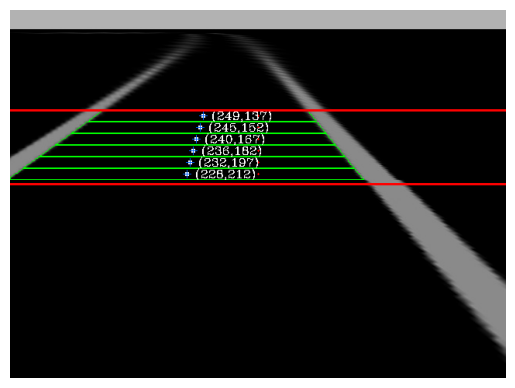

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class ImageClass:
    def __init__(self, image, upper_limit=130, bottom_limit=225, n_slices=6):
        """Inicializa a classe com a imagem e parâmetros opcionais.
        
        Args:
            image (numpy.ndarray): A imagem a ser processada.
            upper_limit (int): Limite superior para o fatiamento da imagem.
            bottom_limit (int): Limite inferior para o fatiamento da imagem.
            n_slices (int): Número de fatias desejadas.
        """
        if image is None or not isinstance(image, np.ndarray):
            raise ValueError("A imagem fornecida não é válida.")
        
        self.image = image
        self.image_out = None
        self.contourCenterX = 0
        self.MainContour = None
        self.n_slices = n_slices
        self.image_slices = []
        self.slice_size = None
        self.detected_points_offset = []
        self.detected_points = []
        self.upper_limit = upper_limit
        self.bottom_limit = bottom_limit

        # Matriz intrínseca e coeficientes de distorção fornecidos
        self.intrinsic_matrix = np.array([[774.608099, 0.0, 342.430253], 
                                          [0.0, 774.119900, 264.814194], 
                                          [0.0, 0.0, 1.0]])
        self.dist_coeffs = np.array([0.102414, -0.221511, 0.013876, 0.019191, 0.0])

        self.camera_height = 0.12  # Altura da câmera em metros
        self.camera_angle = np.radians(15)  # Inclinação da câmera em radianos
        self.camera_distance = 0.125  # Distância da câmera até a frente do robô
        self.clicked_point = None
        
    
    def slice_image(self):
        """Divide a imagem em fatias e armazena em self.image_slices."""
        img = self.image
        height, width = img.shape[:2]
        slice_height = self.bottom_limit - self.upper_limit
        self.slice_size = int(slice_height / self.n_slices)
        
        # Adiciona a fatia superior
        self.image_slices.append(img[0:self.upper_limit, 0:width]) 
        
        # Adiciona as fatias intermediárias
        for i in range(self.n_slices):
            part = self.upper_limit + self.slice_size * i
            crop_img = img[part:part + self.slice_size, 0:width]
            self.image_slices.append(crop_img)

        # Adiciona a fatia inferior
        self.image_slices.append(img[self.bottom_limit:height, 0:width]) 
        
        return self.image_slices
    
    def repack_image(self):
        """Recombina as fatias de volta em uma única imagem."""
        img = self.image_slices[0]
        for i in range(1, len(self.image_slices)):
            img = np.concatenate((img, self.image_slices[i]), axis=0)
        return img

    def process_image(self):
        """Processa a imagem, encontra contornos e calcula offsets."""
        # Começa dividindo a imagem em fatias
        self.slice_image()

        for index in reversed(range(len(self.image_slices[1:-1]))):
            image_slice = self.image_slices[1 + index]
            imgray = cv2.cvtColor(image_slice, cv2.COLOR_BGR2GRAY)  # Converte para escala de cinza
            ret, thresh = cv2.threshold(imgray, 100, 255, cv2.THRESH_BINARY_INV)  # Aplica limiar
            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # Obtém contornos
            
            self.prev_MC = self.MainContour
            self.prev_MCX = self.contourCenterX
            
            if contours:
                self.MainContour = self.findMainContour(contours)
                height, width = image_slice.shape[:2]

                self.middleX = int(width / 2)  # Coordenada X do ponto médio
                self.middleY = int(height / 2)  # Coordenada Y do ponto médio
                
                contourCenter = self.getContourCenter(self.MainContour)
                if contourCenter:    
                    self.contourCenterX = contourCenter[0]
                    cv2.drawContours(image_slice, self.MainContour, -1, (0, 255, 0), 1)  # Desenha o contorno
                    cv2.circle(image_slice, (self.contourCenterX, self.middleY), 3, (255, 255, 255), -1)  # Desenha círculo branco
                    cv2.circle(image_slice, (self.middleX, self.middleY), 1, (0, 0, 255), -1)  # Desenha círculo vermelho
                    
                    point_offset = self.middleX - self.contourCenterX
                    # print('point_offset: ', point_offset)    
                    u = self.contourCenterX
                    v = index * self.slice_size + self.upper_limit + self.slice_size // 2
                    self.detected_points.append([u,v])
                    # cv2.putText(image_slice, str(point_offset), (self.contourCenterX + 10, self.middleY + 5), cv2.FONT_HERSHEY_COMPLEX, .5, (255, 255, 255))
                    cv2.putText(image_slice, f'({round(u, 2)},{round(v, 2)})', (self.contourCenterX + 10, self.middleY + 5), cv2.FONT_HERSHEY_COMPLEX, .5, (255, 255, 255))
                    self.detected_points_offset.append(point_offset)

        self.image_out = self.repack_image()
        final_height, final_width = self.image_out.shape[:2]
        cv2.line(self.image_out, (0, self.bottom_limit), (final_width, self.bottom_limit), (0, 0, 255), 2)
        cv2.line(self.image_out, (0, self.upper_limit), (final_width, self.upper_limit), (0, 0, 255), 2)
        
        # Exibe a imagem processada
        # self.display_image(self.image_out)

    def findMainContour(self, contours):
        """Encontra o contorno principal com base na área e na posição.
        
        Args:
            contours (list): Lista de contornos detectados.

        Returns:
            numpy.ndarray: O contorno principal encontrado.
        """
        biggestContour = max(contours, key=cv2.contourArea)
        if len(self.detected_points_offset):
            if self.getContourCenter(biggestContour):    
                biggestContourX = self.getContourCenter(biggestContour)[0]
                if abs((self.middleX - biggestContourX) - self.detected_points_offset[-1]) > 50:
                    contour = biggestContour
                    contourX = biggestContourX
                    for tmp_contour in contours:
                        if self.getContourCenter(tmp_contour):
                            temp_contourX = self.getContourCenter(tmp_contour)[0]
                            if abs(((self.middleX - temp_contourX) - self.detected_points_offset[-1]) < 
                                    abs(((self.middleX - contourX) - self.detected_points_offset[-1]))):
                                contour = tmp_contour
                                contourX = temp_contourX
                    return contour
                else:
                    return biggestContour
        else:
            return biggestContour

    def getContourCenter(self, contour):
        """Calcula o centro de um contorno.
        
        Args:
            contour (numpy.ndarray): O contorno para o qual o centro será calculado.

        Returns:
            list: Coordenadas [x, y] do centro do contorno.
        """
        M = cv2.moments(contour)
        
        if M["m00"] == 0:
            return [0, 0]
        
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        
        return [x, y]

    def display_image(self, img):
        """Exibe a imagem usando Matplotlib.
        
        Args:
            img (numpy.ndarray): A imagem a ser exibida.
        """
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    def pixel_to_real_world(self, u, v):
        """Function to translate pixel coordinate to real world distance"""

        # Desfaz a distorção do ponto
        points = np.array([[u, v]], dtype=np.float32)
        undistorted_points = cv2.undistortPoints(np.expand_dims(points, axis=1), self.intrinsic_matrix, self.dist_coeffs)
        u_distorted, v_distorted = undistorted_points[0][0]

        # Converte o ponto da imagem para coordenadas reais (X, Z)
        fx = self.intrinsic_matrix[0, 0]  # f_x
        fy = self.intrinsic_matrix[1, 1]  # f_y

        # Coordenadas do pixel em relação ao centro da imagem
        dx = (u_distorted * fx)
        dy = (v_distorted * fy)

        # Calcula o ângulo vertical da câmera em relação ao pixel clicado
        alfa_y = np.arctan2(dy, fy)
        total_theta = self.camera_angle + alfa_y

        if total_theta <= 0:
            total_theta = 1e-5  # Evita divisão por zero

        # Calcula a distância no plano XZ (Z positivo no mundo real)
        Zc = self.camera_height / np.tan(total_theta)
        Xc = Zc * dx / fx
        distance_of_robot = Zc - self.camera_distance
        
        return [Xc, distance_of_robot]
    
    def real_world_to_pixel(self, Xc, distance_of_robot):
        """Function to translate real world coordinates (X, Z) to pixel coordinates (u, v)"""
        # Ajuste da distância do robô para a câmera
        fx = self.intrinsic_matrix[0, 0]  # f_x
        fy = self.intrinsic_matrix[1, 1]  # f_y
        
        Zc = distance_of_robot + self.camera_distance
        dx = Xc * fx / Zc

        # Calcula o ângulo vertical em relação ao plano XZ
        total_theta = np.arctan2(self.camera_height, Zc)
        alfa_y = total_theta - self.camera_angle

        dy = np.tan(alfa_y) * fy
        # Verifica se o ângulo é válido
        if alfa_y <= 0:
            alfa_y = 1e-5  # Previne divisões por zero

        v_distorted = dy / fy
        u_distorted = dx / fx

        # Aplica a distorção para coordenadas de pixel (u, v)
        # Aplica a distorção para coordenadas de pixel (u, v)
        # Prepara os pontos para a projeção
        cx = self.intrinsic_matrix[0][2]
        cy = self.intrinsic_matrix[1][2]

        u = cx + dx 
        v = cy + dy 
        return int(u), int(v)


# Leitura da imagem
img = cv2.imread('assets/04/frame0000.jpg')
processImage = ImageClass(img, upper_limit=130, bottom_limit=225, n_slices=6)

try:
    processImage.process_image()
    print('Pontos detectados: ', processImage.detected_points)  
    img_out = processImage.image_out
    points_out = []
    for point in processImage.detected_points:
        cv2.drawMarker(img_out, point, (255, 100, 0), cv2.MARKER_CROSS, 10)
        point_uv = processImage.pixel_to_real_world(point[0], point[1])
        points_out.append(point_uv)
                    
    print('\nPontos: ', points_out)  
    print('\n:::: ',)  
    points_world = []
    for point in points_out:
        points_world.append(processImage.real_world_to_pixel(point[0], point[1]))
    print('out', points_world)    
    cv2.imwrite('assets/04/out/out.png', img_out),
    
    processImage.display_image(img_out)
except ValueError as e:
    print(f"Erro: {e}")
